In [141]:
from torch import nn, optim
import os
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import default_rng
import torch
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy

In [142]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [143]:
def create_CNN_samples(grid, block, dims = 39):
    
    nonzero = np.transpose(grid[:,:,-2].nonzero()) # Get indices of nonzero componetns
    size = nonzero.shape[0]
    width = block * 2 + 1 # calculate widht and height. Needed later on
    
    X = np.zeros((size, width, width, dims))
    Y = np.zeros(size)
    ID = np.zeros(size)
    Y_1 = np.zeros(size)
    
    for idx, i in enumerate(nonzero):
        x, ID[idx], Y[idx], Y_1[idx] = get_neighbor_grid(grid, i, block)
        X[idx] = x.reshape(width,width, dims)
        
    X = np.moveaxis(X, -1, 1) # order the indices correctly to make sure it works in CNN
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).float()
    
    return X,ID,Y, Y_1

In [144]:
def get_neighbor_grid(full, hw, block = 1):
    
    # get the nonzero (built) blocks by checking if they have a ID

    h = hw[0]
    w = hw[1]
    
    y = full[h,w,-1]
    ID = full[h,w,-2]
    Y_1_train = full[h,w,-3]
    
    hu = h - block
    hd = h + block
    hshort, hextra, wshort, wextra = 0,0,0,0
    if hu < 0:
        hshort = 0 - hu
        hu = 0
    if hd >= full.shape[0]:
        hextra = (hd - full.shape[0]) + 1
        hd = full.shape[0]

    wr = w + block
    wl = w - block

    if wr >= full.shape[1]:
        wextra = (wr - full.shape[1]) + 1
        wr = full.shape[1]
    if wl < 0:
        wshort = 0 - wl
        wl = 0

    nb = full[hu : hd + 1, wl : wr + 1, :]
    nb = np.pad(nb, ((hshort, hextra), (wshort, wextra), (0,0)), mode = "constant", constant_values = 0)
    return nb[:,:,:-3], ID, y, Y_1_train


In [145]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [146]:
df15 = load_data(2015).set_index("C28992R100")
df16 = load_data(2016).set_index("C28992R100")
df17 = load_data(2017).set_index("C28992R100")
df18 = load_data(2018).set_index("C28992R100")
df19 = load_data(2019).set_index("C28992R100")


In [147]:
# Get data that is available in all years
overlapping1517 = df17.index[df17.index.isin(df16.index[df16.index.isin(df15.index)])]
overlapping1518 = df18.index[df18.index.isin(overlapping1517)]
overlapping1519 = df19.index[df19.index.isin(overlapping1518)]




In [148]:
import pickle
with open("cbs_id_koppel.pickle", "rb") as f:
    a = pickle.load(f)
overlap_num = [a[x] for x in overlapping1519]

In [149]:
def get_cnn_time(year, overlap_num):
    X_train = []
    Y_train = []
    ID_train = []
    Y_1_train = []
    for filename in os.listdir("../Data/filled/grids/" + str(year) + "/"):
        n = np.load("../Data/filled/grids/" + str(year) + "/" + filename)
        X, ID, Y, Y_1 = create_CNN_samples(n, 5)
        X_train.append(X)
        Y_train.append(Y)
        ID_train.append(ID)
        Y_1_train.append(Y_1)

    Y = np.concatenate(Y_train)
    ID = np.concatenate(ID_train)
    X = np.concatenate(X_train)
    Y1 = np.concatenate(Y_1_train)
    overlap = np.isin(ID, overlap_num)
    return X[overlap], Y[overlap], ID[overlap], Y1[overlap]

    
# X15c, Y15c, ID15c, Y115c = get_cnn_time(2015, overlap_num)
# X16c, Y16c, ID16c, Y116c = get_cnn_time(2016, overlap_num)
# X17c, Y17c, ID17c, Y117c = get_cnn_time(2017, overlap_num)
# X18c, Y18c, ID18c, Y118c = get_cnn_time(2018, overlap_num)
# X19c, Y19c, ID19c, Y119c = get_cnn_time(2019, overlap_num)


In [150]:
# Fill X and Y
block_size = get_cnn_time(2015, overlap_num)[0].shape[-1]
X = np.zeros((len(overlapping1519), 5, 39, block_size, block_size))
Y = np.zeros((len(overlapping1519), 5))
Y_1 = np.zeros((len(overlapping1519), 5))
ID = np.zeros((len(overlapping1519), 5))
ss = StandardScaler()


for i, year in enumerate([2015, 2016, 2017, 2018, 2019]):
    X[:,i], Y[:,i], ID[:,i], Y_1[:,i] = get_cnn_time(year, overlap_num)

In [151]:
# Create neighbor lists for all years

df15 = df15.loc[overlapping1519]
df16 = df16.loc[overlapping1519]
df17 = df17.loc[overlapping1519]
df18 = df18.loc[overlapping1519]
df19 = df19.loc[overlapping1519]


w15 = libpysal.weights.DistanceBand.from_dataframe(df15.reset_index(), threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16.reset_index(), threshold=150, binary = True, silence_warnings = True)
w17 = libpysal.weights.DistanceBand.from_dataframe(df17.reset_index(), threshold=150, binary = True, silence_warnings = True)
w18 = libpysal.weights.DistanceBand.from_dataframe(df18.reset_index(), threshold=150, binary = True, silence_warnings = True)
w19 = libpysal.weights.DistanceBand.from_dataframe(df19.reset_index(), threshold=150, binary = True, silence_warnings = True)

In [152]:
# create Y(t-1) for all years

def get_y_1(y1, w):
    neighbors = [w.neighbors[x] for x in w.neighbors]
    y1 = np.array([y1[x].sum() for x in neighbors])
    y1[np.where(y1 == 0)[0]] = 0.5

    return y1

Y1_15 = get_y_1(Y_1[:,0], w15)
Y1_16 = get_y_1(Y_1[:,1], w16)
Y1_17 = get_y_1(Y_1[:,2], w17)
Y1_18 = get_y_1(Y_1[:,3], w18)
Y1_19 = get_y_1(Y_1[:,4], w19)



In [153]:
# X train is the first three years
X_train = X[:,:3]
Y_train = Y[:,2]

X_train = np.moveaxis(X_train, 2 ,-1)
X_train = X_train.reshape(-1, 39)
X_train = ss.fit_transform(X_train)
X_train = np.append(X_train.reshape(Y1_17.shape[0], -1), Y1_17.reshape(-1,1), axis = 1)

In [154]:
smote = SMOTE()
X_train_resample,Y_train_resample = smote.fit_resample(X_train,Y_train)

Y1_17r = X_train_resample[:,-1]
Y1_17r[Y1_17r>0.5] =  np.ceil(Y1_17r[Y1_17r > 0.5])

X_train_resample = np.delete(X_train_resample, -1, -1)
X_train_resample = X_train_resample.reshape(X_train_resample.shape[0], 3, block_size, block_size, 39)
X_train_resample = np.moveaxis(X_train_resample, -1, 2)

In [155]:
X_val = X[:,:4]
Y_val = Y[:,3]
X_val = np.moveaxis(X_val, 2, -1)
X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(Y_val.shape[0], 4, block_size, block_size, 39)
X_val = np.moveaxis(X_val, -1, 2)

X_val = torch.tensor(X_val).float()
X_train_resample = torch.tensor(X_train_resample).float()
Y_train_resample = torch.tensor(Y_train_resample).float()
Y1_17r = torch.tensor(Y1_17r).float()
Y1_18 = torch.tensor(Y1_18).float()

In [156]:
X_test = X[:,:5]
Y_test = Y[:,4]
X_test = np.moveaxis(X_test, 2, -1)
X_test = X_test.reshape(-1, 39)
X_test = ss.transform(X_test)
X_test = X_test.reshape(Y_test.shape[0], 5, block_size, block_size, 39)
X_test = np.moveaxis(X_test, -1, 2)
X_test = torch.tensor(X_test).float()
Y1_19 = torch.tensor(Y1_19).float()

In [157]:
rng = default_rng()
def get_batch(X, Y, Y1, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs], Y1[idxs]



In [158]:
class RNNCNN(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 40, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 40, out_channels = 40, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 79 ,hidden_size = 200, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(200,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,5,5] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 200).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [159]:
class RNNCNN1(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN1, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 15, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 15, out_channels = 5, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 44 ,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,5,5] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 100).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [160]:
class RNNCNN2(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN2, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 5, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 5, out_channels = 20, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 59 ,hidden_size = 150, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(150,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,5,5] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 150).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [161]:
class RNNCNN3(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN3, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 5, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 5, out_channels = 5, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 44 ,hidden_size = 75, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(75,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,5,5] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 75).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X


In [162]:
models = [0,1,2,3]

In [163]:
def train(model, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs,lr, batch_per_e =100 ):
    
    train_loss = []
    train_loss_history = []
    acc_history = []
    ROC_history = []
    f1_score_history = []
    val_loss_history = []
    best_auc = 0
    best_f1 = 0
    best_model = np.NaN

    for i, size in enumerate(models):
        for lr in [0.0000051, 0.00000051]:

            if size == 0: model = RNNCNN()         
            elif size ==1: model = RNNCNN1()                
            elif size == 2: model = RNNCNN2()
            elif size == 3: model = RNNCNN3()

            optimizer = optim.RMSprop(model.parameters(), lr = lr) 
            SigBCEloss = nn.BCEWithLogitsLoss()

            for epoch in range(num_epochs):
                print(epoch)
                epoch_loss = []
                for batch in range(batch_per_e):
                    x, y, y1 = get_batch(X_train, Y_train, Y1_train, 6)

                    model.train()
                    optimizer.zero_grad()
                    out = model(x, y1).squeeze()
                    loss = SigBCEloss(out, y)
                    loss.backward()
                    optimizer.step()
                    epoch_loss.append(loss.cpu().detach().numpy())

                model.eval()
                out = model(X_val, Y1_val) 
                ROC = roc_auc_score(Y_val, model.final(out).detach())
                val_loss = SigBCEloss(out, torch.tensor(Y_val).float())
                preds = np.zeros(len(out))
                pos = out.argsort()[-((Y_val == 1).sum()):]
                preds[pos] = 1

                f1 = f1_score(Y_val, preds)

                acc = accuracy_score(Y_val, preds)

                if ROC > best_auc:
                    print(ROC, f1, size, lr)
                    best_auc = ROC
                    best_model = deepcopy(model.state_dict())




                acc_history.append(acc)
                ROC_history.append(ROC)
                train_loss_history.append(np.sum(epoch_loss) / batch_per_e)
                f1_score_history.append(f1)
                val_loss_history.append(val_loss.detach().numpy())

            plt.plot(train_loss_history, alpha = 0.5)
            plt.hlines(np.mean(train_loss_history), 0, n_epochs, color = "r")
            plt.plot(val_loss_history, alpha = 0.5, color = "green")
            plt.show()


            plt.plot(ROC_history, alpha = 0.5)
            plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r")
            plt.show()

            train_loss = []
    print(out)
    result = np.argmax(ROC_history)
    print("best auc: {}, f1: {}, epoch: {}".format(ROC_history[result], f1_score_history[result], result))
    return acc_history, ROC_history, train_loss_history, f1_score_history, val_loss_history, best_model

0
0.4677084835159554 0.06862745098039216 0 5.1e-06
1
0.47959168348712033 0.08333333333333333 0 5.1e-06
2
0.5084169850538254 0.09313725490196079 0 5.1e-06
3
0.5420225994809688 0.10294117647058823 0 5.1e-06
4
0.5787940635813149 0.11274509803921569 0 5.1e-06
5
0.6009820441657056 0.11764705882352941 0 5.1e-06
6
0.6196722714821222 0.12745098039215685 0 5.1e-06
7
0.6355435709823145 0.13725490196078433 0 5.1e-06
8
0.6506744701557092 0.14215686274509803 0 5.1e-06
9
0.6579831074586697 0.13725490196078433 0 5.1e-06
10
0.6630390054306036 0.14705882352941177 0 5.1e-06
11
0.6660501670030756 0.14705882352941177 0 5.1e-06
12
0.668794003508266 0.1568627450980392 0 5.1e-06
13
0.6699579188292963 0.16176470588235295 0 5.1e-06
14
0.6714439758746635 0.16666666666666666 0 5.1e-06
15
16
17
18
19
20
0.6715295799692425 0.18137254901960784 0 5.1e-06
21
22
23
24
25
26
27
28
29
30
31
0.6723495770857363 0.18627450980392157 0 5.1e-06
32
0.6732093725970781 0.1911764705882353 0 5.1e-06
33
0.6733580533929259 0.2009803

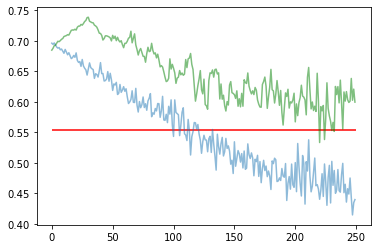

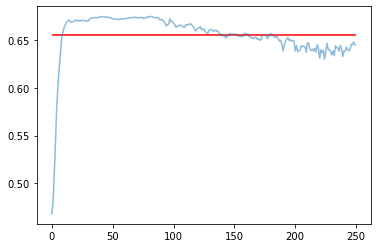

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
0.6756994004709729 0.18137254901960784 0 5.1e-07
83
0.6764225297962322 0.18137254901960784 0 5.1e-07
84
0.6769887182814303 0.18627450980392157 0 5.1e-07
85
0.6780797950307574 0.18627450980392157 0 5.1e-07
86
0.6790492238562091 0.18627450980392157 0 5.1e-07
87
0.6797167856113033 0.18627450980392157 0 5.1e-07
88
0.6802108864379085 0.18627450980392157 0 5.1e-07
89
0.6808852064109956 0.18627450980392157 0 5.1e-07
90
0.6813560289311803 0.18627450980392157 0 5.1e-07
91
0.6815775482987312 0.18627450980392157 0 5.1e-07
92
0.6818846717608612 0.18627450980392157 0 5.1e-07
93
0.6823337178008457 0.18627450980392157 0 5.1e-07
94
0.6825815191272587 0.18137254901960784 0 5.1e-07
95
0.683010290513264 0.18137254901960784 0 5.1e-07
96
0.6834270472895041 0.1813725490196

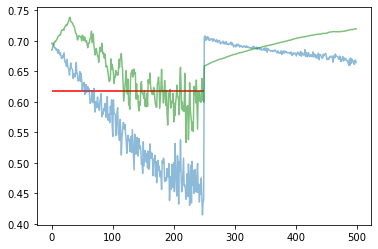

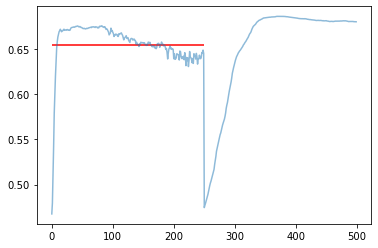

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
0.6859936683006536 0.20588235294117646 1 5.1e-06
202
0.6861265799211841 0.20588235294117646 1 5.1e-06
203
204
0.6861934111880047 0.20588235294117646 1 5.1e-06
205
0.6862114331026529 0.20588235294117646 1 5.1e-06
206
207
0.6863000408496732 0.20588235294117646 1 5.1e-06
208
0.6863360846789697 0.20588235

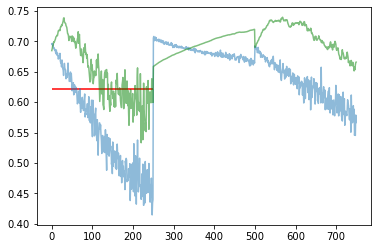

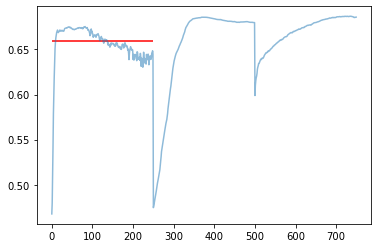

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


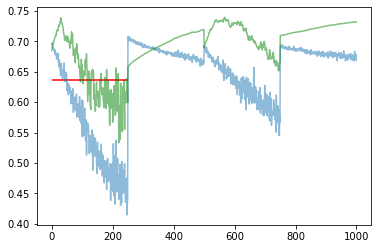

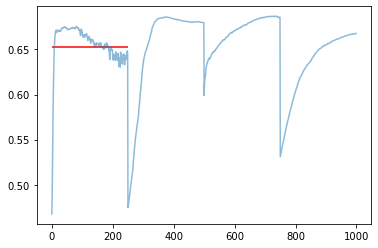

0
1
2
3
4
0.6878266472029988 0.23039215686274508 2 5.1e-06
5
0.692136888456363 0.22058823529411764 2 5.1e-06
6
0.694351331218762 0.22058823529411764 2 5.1e-06
7
0.6952216395136487 0.23529411764705882 2 5.1e-06
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0.6952952289984621 0.18137254901960784 2 5.1e-06
55
0.6953230127835449 0.1911764705882353 2 5.1e-06
56
0.6954236351403306 0.18627450980392157 2 5.1e-06
57
0.6959395124471357 0.18627450980392157 2 5.1e-06
58
0.6959537797962322 0.18627450980392157 2 5.1e-06
59
60
61
62
63
0.6960348784121493 0.18627450980392157 2 5.1e-06
64
0.6963818002691272 0.18627450980392157 2 5.1e-06
65
0.6965935577662438 0.18627450980392157 2 5.1e-06
66
67
0.6968548755286428 0.1911764705882353 2 5.1e-06
68
0.6970448565455594 0.1911764705882353 2 5.1e-06
69
0.6973189398308344 0.1911764705882353 2 5.1e-06
70
71
72
73
74
75
76
77
78
79
80
0.6973805147058824 0.19607843137254902

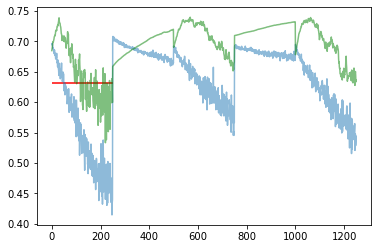

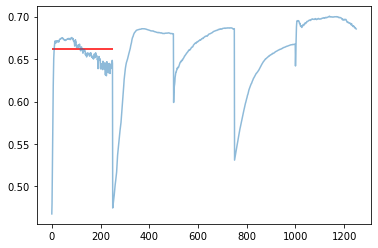

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


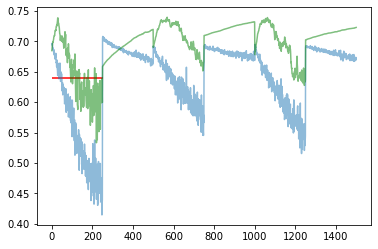

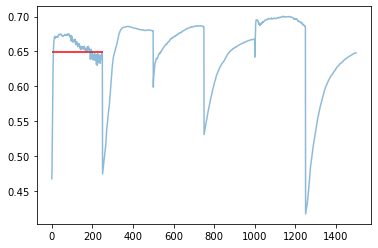

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


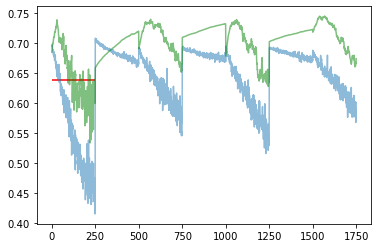

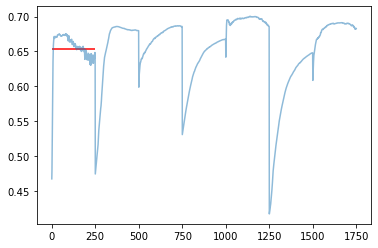

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


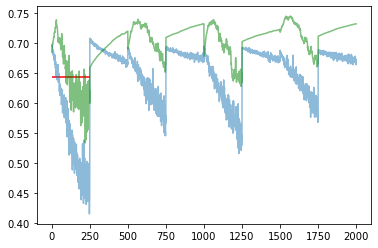

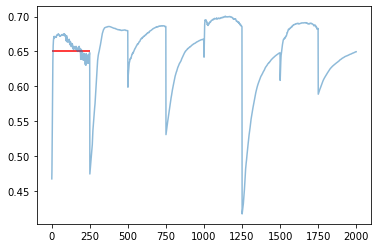

tensor([-0.0220, -0.0084, -0.0084,  ..., -0.0048, -0.0243, -0.0251],
       grad_fn=<MulBackward0>)
best auc: 0.700384167147251, f1: 0.21568627450980393, epoch: 1140


In [164]:
n_epochs = 250
hists = train(models, X_train_resample, Y_train_resample, Y1_17r, X_val, Y_val, Y1_18, n_epochs,5.1e-06)



In [75]:

hists

([0.6902149062642889,
  0.696159122085048,
  0.7059899405578418,
  0.7112482853223594,
  0.7210791037951532,
  0.7327389117512574,
  0.7363968907178784,
  0.7391403749428441,
  0.7405121170553269,
  0.7437128486511203,
  0.7462277091906722,
  0.7466849565614998,
  0.747599451303155,
  0.7480566986739826,
  0.7489711934156379,
  0.7489711934156379,
  0.7498856881572931,
  0.751257430269776,
  0.7519433013260174,
  0.7528577960676726,
  0.7526291723822588,
  0.7535436671239141,
  0.7535436671239141,
  0.7537722908093278,
  0.7542295381801555,
  0.7533150434385002,
  0.7537722908093278,
  0.7546867855509831,
  0.7556012802926383,
  0.7556012802926383,
  0.7558299039780522,
  0.7549154092363969,
  0.7562871513488797,
  0.7562871513488797,
  0.7556012802926383,
  0.7565157750342936,
  0.757201646090535,
  0.757201646090535,
  0.757201646090535,
  0.7565157750342936,
  0.7562871513488797,
  0.7567443987197073,
  0.7569730224051212,
  0.7567443987197073,
  0.7565157750342936,
  0.756973022405


# test

In [166]:
model = RNNCNN2()
model.load_state_dict(hists[-1])
model.eval()

out = model(X_test, Y1_19)

ROC = roc_auc_score(Y_test, model.final(out).detach().numpy())
out = out.squeeze().detach().numpy()

preds = np.zeros(len(out))
pos = out.argsort()[-((Y_test == 1).sum()):]
preds[pos] = 1

f1 = f1_score(Y_test, preds)
print(ROC, f1)
with open ("../Results/Nijmegen.csv", "a+") as f:
    f.write("\nRNNCNN,{},{}".format(ROC,f1))

0.6485434050651442 0.23140495867768596


X_val


In [ ]:
class RNNCNN(nn.Module): # auc: 0.692
    def __init__(self):
        super(RNNCNN, self).__init__()
        self.conv = nn.Sequential(
             nn.Conv2d(in_channels= 39, out_channels = 15, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 15, out_channels = 2, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten()
         
        )
        self.GRU = nn.GRU(input_size = 57 ,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
        )
        self.final = nn.Sigmoid()
        
    def forward(self, X, Y1):
        orig = X[:,:,:,10,10] # original cells are at the center of 11*11 point
        
        batch_size, timesteps, C, H, W = X.size()
        
        c_in = X.view(batch_size * timesteps, C, H, W)
        c_out = self.conv(c_in)
        
        # reshape and concatenate the original data
        r_in = c_out.view(batch_size, timesteps, -1)
        r_in = torch.cat((orig, r_in), axis = 2)
        
        h0 = torch.zeros(1, X.size(0), 100).to(device)
        
        X, _ = self.GRU(r_in, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X
